In [1]:
import os
import random
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import normalize

# Data Preprocessing

Extract simple features like label, speaker ID, text ID, sex of speaker, length of sample, mean signal amplitude, variance signal aplitude and put everything in pandas DataFrame for easy handling.

In [2]:
data = {'sample':[],
        'label':[],
        'speaker_ID':[],
        'sex':[],
        'text_ID':[],
        'length':[],
        'max':[],
        'min':[],
        'mean':[],
        'median':[],
        'var':[],
        'sample freq[Hz]':[]}
files = os.listdir('./wav/')
mf_dict = {'03':'M','08':'F','09':'F','10':'M','11':'M','12':'M','13':'F','14':'F','15':'M','16':'F'}
for f in files:
    sf, sample = wavfile.read('./wav/'+f)
    data['sample'].append(sample)
    data['speaker_ID'].append(f[:2])
    data['text_ID'].append(f[2:5])
    data['label'].append(f[5])
    data['length'].append(len(sample))
    data['max'].append(np.max(sample))
    data['min'].append(np.min(sample))
    data['mean'].append(np.mean(sample))
    data['median'].append(np.median(sample))
    data['var'].append(np.var(sample))
    data['sex'].append(mf_dict[f[:2]])
    data['sample freq[Hz]'].append(sf)

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [3]:
df = pd.DataFrame(data)
df.to_pickle('data.pkl')
df.head()

,sample,label,speaker_ID,sex,text_ID,length,max,min,mean,median,var,sample freq[Hz]
0,"[9, 19, 24, 24, 29, 32, 37, 39, 42, 39, 47, 49...",F,08,F,a04,28810,31966,-32760,-12.302742,24.0,1.291753e+07,16000
1,"[19, -9, -9, -29, -19, -9, -29, -29, -19, -9, ...",T,11,M,b03,94480,32765,-31169,-48.151344,-19.0,1.049511e+07,16000
2,"[1, 0, -5, -2, -5, -6, -8, -5, -8, -8, -4, -4,...",W,11,M,a01,30716,32767,-25381,-6.819508,-5.0,8.791536e+06,16000
3,"[1, 0, -5, -1, -7, -1, 0, 0, -3, -5, 1, 5, 1, ...",W,12,M,a02,23453,32767,-30394,-8.992069,-9.0,2.103275e+07,16000
4,"[0, 0, 12, -12, -18, -25, 0, 18, 6, 12, -6, 0,...",N,15,M,a07,30099,32608,-32765,-23.606366,151.0,2.899903e+07,16000


**Key Idea:** To split the data in train, test and validation set it is reasonable to split them by speakers. In a real life situation the new data arriving would also come from a totally new speaker. Therefore the models performance should be evaluateed on a speaker which it never heard before.

**Key Idea:** Characteristics of emotional speech might be different for female and male speakers, thus make sure there is one speaker of each gender in the validation set and test set. Since the whole database consists only of little more than 500 samples, which is already pretty small, this will lessen the size of the training set even more. This issue will be addressed later...

In [4]:
male_df = df[df['sex']=='M']
female_df = df[df['sex']=='F']
max_len= max(male_df['length'].max(),female_df['length'].max())

In [5]:
def train_test_val_split(df):
    IDs = list(set(df['speaker_ID']))
    test_speaker_ID = IDs[random.randint(0,len(IDs)-1)]
    IDs.remove(test_speaker_ID)
    val_speaker_ID = IDs[random.randint(0,len(IDs)-1)]
    test_df = df[df['speaker_ID']==test_speaker_ID]
    val_df = df[df['speaker_ID']==val_speaker_ID]
    train_df = df[df['speaker_ID']!=test_speaker_ID]
    train_df = train_df[train_df['speaker_ID']!=val_speaker_ID]
    # Sanity check
    print(set(test_df['speaker_ID']), set(train_df['speaker_ID']), set(val_df['speaker_ID']))
    return train_df, test_df, val_df

# Modeling

**Key Idea:** Sound consists of a superposition of different frequencies, by finding characteristic frequencies (or frequency patterns) of different emotions a classification becomes feasible. Speech is not static, therefore I like to keep the time dimension, thus a frequency spectrum over time intervals is useful. By converting our one-dimensional time series into a two-dimensional image (x-axis is time, y-axis is freq.-sprectrum) we arrive at the image classification task.

Librosa offers a variety of features to extract from audio signals. For the sake of simplicity I just take the Mel-spectrum into account, it is a commonly used feature for speech recognition and audio classification [https://en.wikipedia.org/wiki/Mel-frequency_cepstrum].

In [6]:
def extract_features(df, max_len, stretch_data = False):
    label_map = {'F':0,'T':1,'W':2,'N':3,'L':4,'A':5,'E':6}
    array = []
    labels = []
    for idx, row in df.iterrows():
        sample = np.float32(row['sample'])
        # Data augmentation by stretching or squeezing the sample randomly by a factor of Uni[0.5,1.5]
        if stretch_data == True:
            factor = np.random.uniform() + 0.5
            sample = librosa.effects.time_stretch(sample, rate =  factor)
            # if a streched sample is longer than the longest unaltered sample we crop it
            if len(sample) > max_len:
                sample = sample[:max_len]
        # samples shorter than the longest sample are getting padded with zeros
        sample = np.pad(sample,(0,max_len-len(sample)),'constant',constant_values=0.)
        mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=sample,sr=16000,n_fft=4096), ref=np.max)
        array.append(mel_spec)
        labels.append(label_map[row['label']])
    return np.expand_dims(np.array(array),-1), np.int32(np.array(labels))

Normalize data to benefit training, physical meaning of values (decibel) is not of importance here. 

In [7]:
def normalize(train, test, val):
    max_ = train.max()
    min_ = train.min()
    train = (train - min_)/(max_ - min_)
    test = (test - min_)/(max_ - min_)
    val = (val - min_)/(max_ - min_)
    return train, test, val

**Key Idea:** As mentioned above the size of our dataset is pretty small, this will significantly influence our training since we are in huge danger of overfitting our model. Here some simple data augmentation strategies are employed: shifting the spectrum forward in time by a quater and a half second, stretch the signals by a random factor Uni[0.5,1.5] before calculating mel-spectrum (see extract_features()) and adding gaussian zero-centered noise with 5% of mean spectrum strength as standard deviation.

This will augment our training data by a factor of 4 and help to prevent overfitting.

In [8]:
def augment_data(train, train_labels, train_df):
    train_stretched, _ = extract_features(train_df,max_len, stretch_data=True)
    train = np.vstack([train,
                       np.roll(train,shift=4000,axis=2),
                       np.roll(train,shift=8000,axis=2),
                       train_stretched,
                       train + 0.05*np.mean(train)*np.random.randn(train.shape[0],train.shape[1],train.shape[2],train.shape[3]),
                       np.flip(train,axis=2)])
    train_labels_aug = np.hstack(np.tile(train_labels,6))
    return train, train_labels_aug

In [9]:
def preprocessing(df):
    train_df, test_df, val_df = train_test_val_split(df)
    test, test_labels = extract_features(test_df, max_len)
    train, train_labels = extract_features(train_df, max_len)
    train, train_labels = augment_data(train, train_labels, train_df)
    val, val_labels = extract_features(val_df, max_len)
    return train, test, val, train_labels, test_labels, val_labels

Apply all preprocessing steps and normalize. Compute class weights to deal with call minor imbalances.

In [10]:
train_m, test_m, val_m, train_labels_m, test_labels_m, val_labels_m = preprocessing(male_df)
train_f, test_f, val_f, train_labels_f, test_labels_f, val_labels_f = preprocessing(female_df)

train_ = np.vstack([train_m, train_f])
train_labels = np.hstack([train_labels_m, train_labels_f])
test = np.vstack([test_m, test_f])
test_labels = np.hstack([test_labels_m, test_labels_f])
val = np.vstack([val_m, val_f])
val_labels = np.hstack([val_labels_m, val_labels_f])

train, test, val = normalize(train_, test, val)

_, test_m, test_f = normalize(train_, test_m, test_f)

class_weights = compute_class_weight('balanced',np.unique(train_labels),train_labels)

{'10'} {'03', '11', '15'} {'12'}
{'14'} {'08', '16', '09'} {'13'}


Small CNN architecture: 2 conv-layers with max-pooling, and two dense layers. Usage of dropout after the first dense layer to further regularize and prevent overfitting.

In [11]:
ip = Input(shape=test[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu',padding='same')(m)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Flatten()(m)
m = Dense(128, activation='relu')(m)
m = Dropout(0.2)(m)
op = Dense(7, activation='softmax')(m)
model = Model(inputs=ip, outputs=op)
model.summary()

W0730 14:51:06.826691 140166696359552 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 281, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 281, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 70, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 70, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 17, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8704)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               111424

Train model with some Neural Network best practices (runs approx. 5min on my notebook without GPU): use validation data to see if model generalizes well and when it starts overfitting, save model with lowest validation error as best model, use class weights to encounter class imbalances.

In [12]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
chk = ModelCheckpoint('best_model.pkl', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
hist = model.fit(train,
                 to_categorical(train_labels),
                 batch_size=32,
                 epochs=10,
                 shuffle=True,
                 class_weight=class_weights,
                 callbacks = [chk],
                 validation_data=(val, to_categorical(val_labels)))

Train on 1992 samples, validate on 96 samples
Epoch 1/10
1992/1992 [==============================] - 36s 18ms/sample - loss: 1.9051 - acc: 0.2254 - val_loss: 1.8431 - val_acc: 0.3021
Epoch 2/10
1992/1992 [==============================] - 36s 18ms/sample - loss: 1.7451 - acc: 0.3353 - val_loss: 1.5437 - val_acc: 0.4167
Epoch 3/10
1992/1992 [==============================] - 35s 17ms/sample - loss: 1.3943 - acc: 0.4664 - val_loss: 1.3989 - val_acc: 0.4479
Epoch 4/10
1992/1992 [==============================] - 34s 17ms/sample - loss: 1.2121 - acc: 0.5361 - val_loss: 1.1455 - val_acc: 0.5104
Epoch 5/10
1992/1992 [==============================] - 39s 20ms/sample - loss: 1.0828 - acc: 0.5547 - val_loss: 1.0357 - val_acc: 0.5729
Epoch 6/10
1992/1992 [==============================] - 36s 18ms/sample - loss: 1.0052 - acc: 0.5994 - val_loss: 0.9669 - val_acc: 0.6354
Epoch 7/10
1992/1992 [==============================] - 34s 17ms/sample - loss: 0.8837 - acc: 0.6506 - val_loss: 0.9053 - val_

In [13]:
model = load_model('best_model.pkl')
print("Test set:")
model.evaluate(test, to_categorical(test_labels))
print("Male speakers of Test set:")
model.evaluate(test_m, to_categorical(test_labels_m))
print("Female speakers of Test set:")
model.evaluate(test_f, to_categorical(test_labels_f,num_classes=7))
print("Val set:")
model.evaluate(val, to_categorical(val_labels))
print("Train set:")
model.evaluate(train, to_categorical(train_labels))

W0730 14:56:59.848945 140166696359552 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 14:56:59.849900 140166696359552 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Test set:
107/107 [==============================] - 1s 6ms/sample - loss: 0.7175 - acc: 0.7103
Male speakers of Test set:
38/38 [==============================] - 0s 5ms/sample - loss: 0.7098 - acc: 0.7105
Female speakers of Test set:
69/69 [==============================] - 0s 5ms/sample - loss: 0.7218 - acc: 0.7101
Val set:
96/96 [==============================] - 0s 5ms/sample - loss: 0.8129 - acc: 0.6771
Train set:
1992/1992 [==============================] - 10s 5ms/sample - loss: 0.4376 - acc: 0.8604


[0.43761757746279, 0.86044174]

# Data Visualizations & Results

Explore data by looking at class imbalances, samples per text, distribution of sample length, samples per speaker, number of samples spoken by females and males.

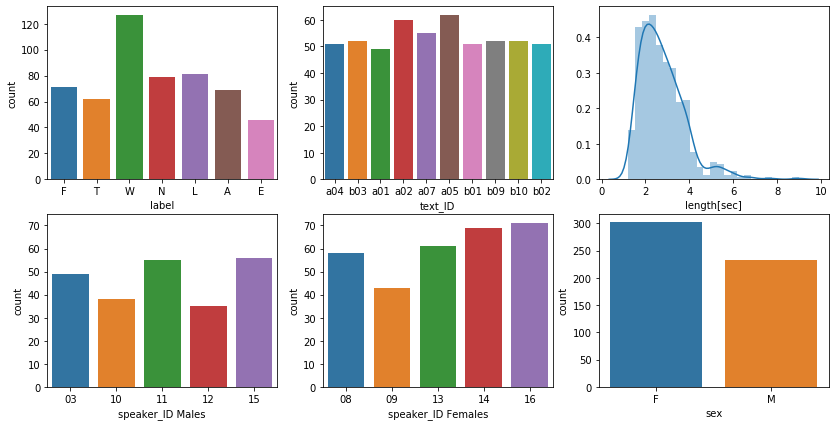

In [14]:
f, axes = plt.subplots(2, 3, figsize=(14, 7))
sns.countplot(x='label',data=df,ax=axes[0,0])
sns.countplot(x='speaker_ID',data=df[df['sex']=='M'],ax=axes[1,0])
axes[1,0].set(xlabel='speaker_ID Males')
sns.countplot(x='speaker_ID',data=df[df['sex']=='F'],ax=axes[1,1])
axes[1,1].set(xlabel='speaker_ID Females')
axes[1,0].set_ylim(0,75)
axes[1,1].set_ylim(0,75)
sns.countplot(x='text_ID',data=df,ax=axes[0,1])
sns.distplot(df['length']/16000,ax=axes[0,2])
axes[0,2].set(xlabel='length[sec]')
sns.countplot(x='sex',data=df,ax=axes[1,2])
plt.savefig('data_info.png',dpi=100)

Have a look at the label distribution per speaker...

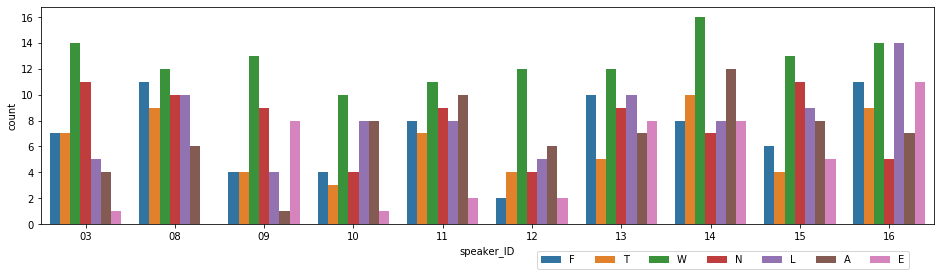

In [15]:
plt.figure(figsize=(16,4))
sns.countplot(x='speaker_ID',hue='label',data=df)
plt.legend(loc='upper left', bbox_to_anchor=(0.55, -0.1), ncol=7)
plt.savefig('classes-per-speaker.png',dpi=100)

Let's explore the text distribution per speaker a little bit more...

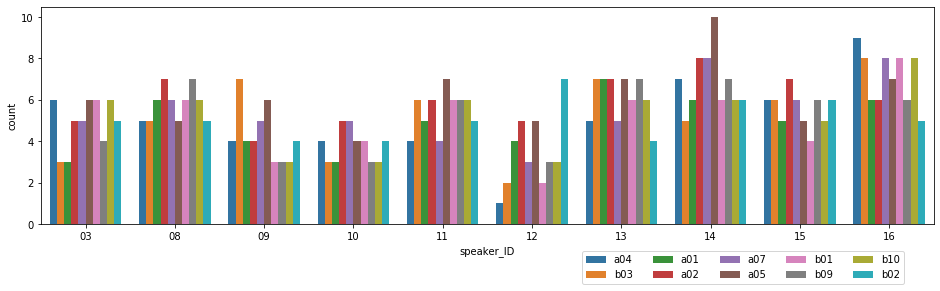

In [16]:
plt.figure(figsize=(16,4))
sns.countplot(x='speaker_ID',hue='text_ID',data=df)
plt.legend(loc='upper left', bbox_to_anchor=(0.6, -0.1), ncol=5)

Check if there are any relationships, correlations or clusters between any of the simple numeric features. Sadly not...

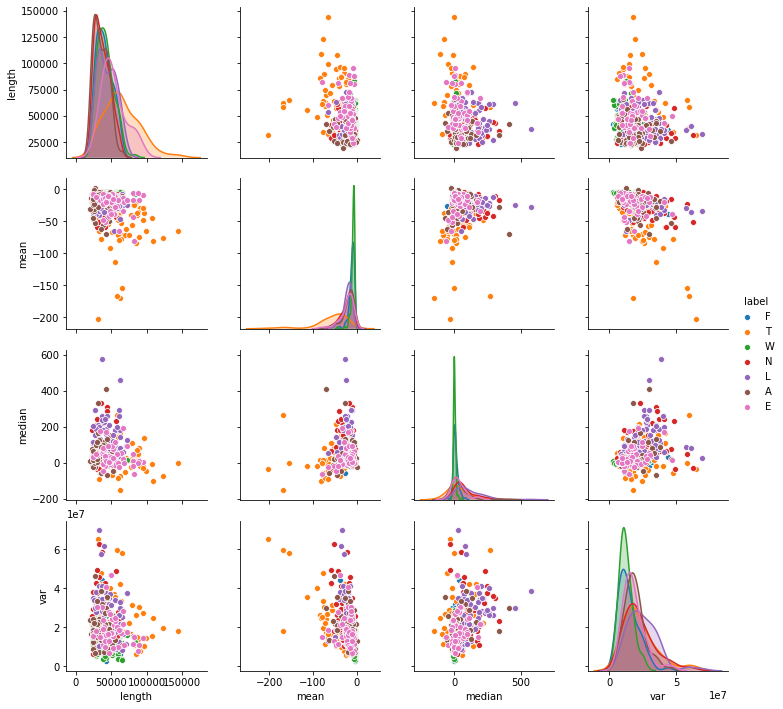

In [17]:
sns.pairplot(df,vars=['length','mean','median','var'],hue='label')

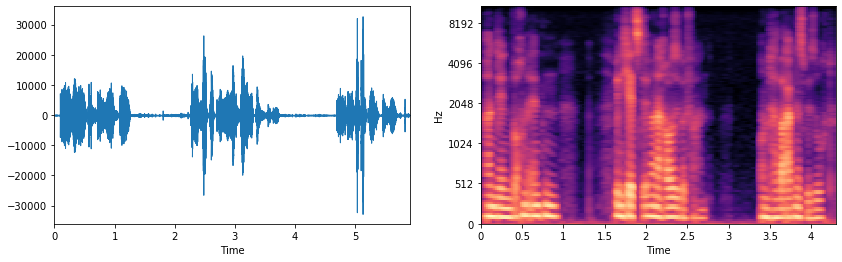

In [18]:
example = np.float32(df['sample'][1])
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
librosa.display.waveplot(example,sr=16000)
plt.subplot(1,2,2)
mel_spec_example = librosa.feature.melspectrogram(y=example,sr=16000,n_fft=4096)
librosa.display.specshow(librosa.power_to_db(mel_spec_example,ref=np.max),y_axis='mel',x_axis='time')
plt.savefig('mel_spec.png',dpi=100)
plt.show()

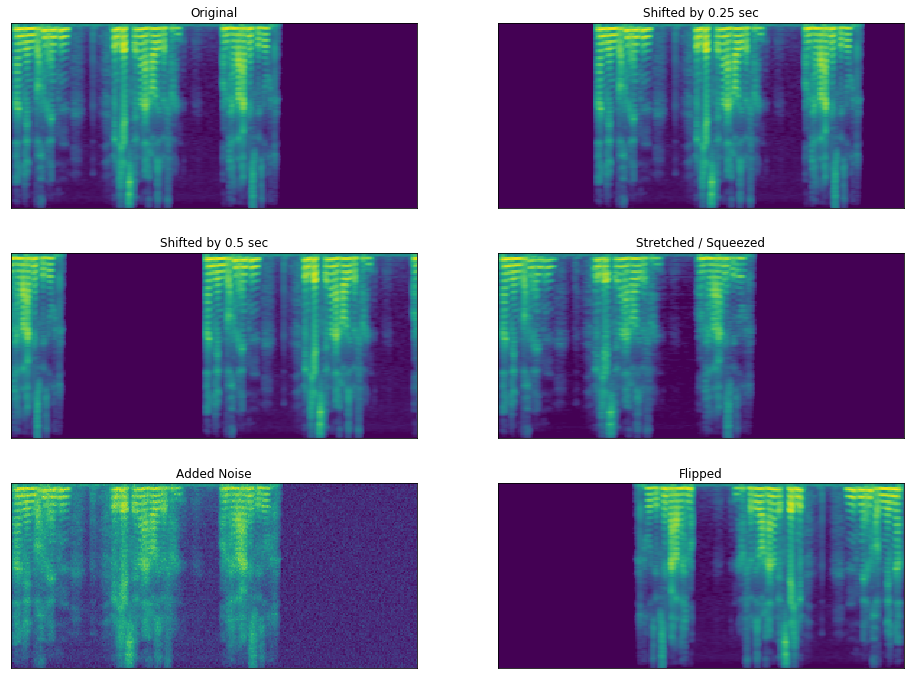

In [19]:
fig, axes = plt.subplots(3,2, figsize=(16,12))
for i in range(6):
    axes.flat[i].imshow(train_m[np.int32(len(train_m)*i/6),:,:,0])
    axes.flat[i].get_xaxis().set_visible(False)
    axes.flat[i].get_yaxis().set_visible(False)
axes.flat[0].set_title('Original')
axes.flat[1].set_title('Shifted by 0.25 sec')
axes.flat[2].set_title('Shifted by 0.5 sec')
axes.flat[3].set_title('Stretched / Squeezed')
axes.flat[4].set_title('Added Noise')
axes.flat[5].set_title('Flipped')
plt.savefig('data_augmentation.png',dpi=100)
plt.show()

Look at accucary and loss evolving over training time particulary to check if or when we are overfitting. In any case we just use the model with the lowest validation loss to prevent overfitting, the danger of overfitting the validation set however still remains...

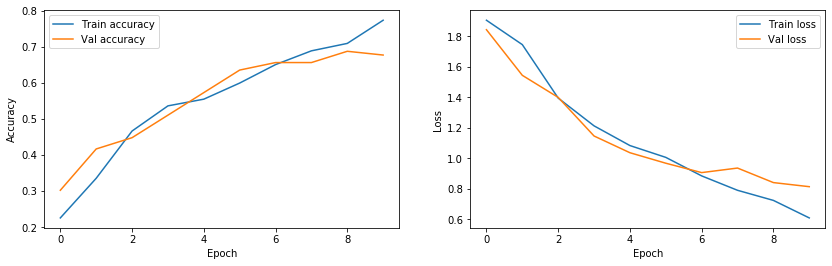

In [20]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(hist.history['acc'],label='Train accuracy')
plt.plot(hist.history['val_acc'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],label='Train loss')
plt.plot(hist.history['val_loss'],label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png',dpi=100)
plt.show()

Heatmap function stolen from: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

In [21]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """
    
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Plot confusion matrix to see which classes are the weakness / strength of our model.

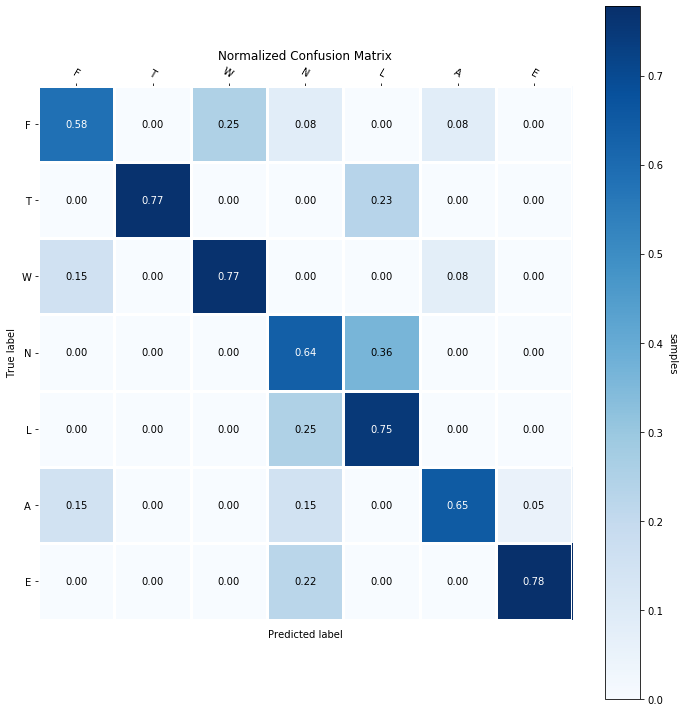

In [29]:
pred = model.predict(test)
pred = np.argmax(pred,axis=1)
cm = confusion_matrix(test_labels,pred)
cm_norm = (cm.transpose() / cm.sum(axis=1)).transpose()
labels = ['F','T','W','N','L','A','E']

fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(cm_norm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="samples")
texts = annotate_heatmap(im, valfmt="{x:1.2f}")

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Normalized Confusion Matrix')
fig.tight_layout()
plt.savefig('confusion_matrix.png',dpi=100)
plt.show()

Look at Precision, Recall and F1-score.

$Precision = \frac{TP}{TP + FP}$ How many selected items are relevant?

$Recall = \frac{TP}{TP + FN}$ How many relevant items are selected?

$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ Harmonic mean of Precision and Recall

Micro: For all classes\
Macro: Average for each class\
Weighted: Weighted average for each class, takes class imbalances into account

<function matplotlib.pyplot.show(*args, **kw)>

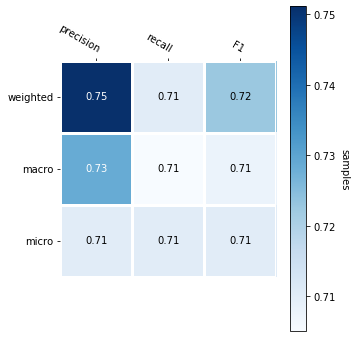

In [30]:
weighted = precision_recall_fscore_support(test_labels, pred,average='weighted')[:-1]
macro = precision_recall_fscore_support(test_labels, pred,average='macro')[:-1]
micro = precision_recall_fscore_support(test_labels, pred,average='micro')[:-1]
eval_mat = np.array([weighted,macro,micro])
eval_mat

fig, ax = plt.subplots(figsize=(5,5))

im, cbar = heatmap(eval_mat, ['weighted','macro','micro'], ['precision','recall','F1'], ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="samples")
texts = annotate_heatmap(im, valfmt="{x:1.2f}")
fig.tight_layout()
plt.savefig('precision_recall_f1.png',dpi=100)
plt.show

Let's do a quick binomial test to check the p-value and confidence interval with R:\
$H_0$: model is randomly guessing $p = \frac{1}{7}$\
$H_A$: model is not randomly guessing, $p \neq \frac{1}{7}$\
Using the results of the test set, 76 samples correct out of 107 samples total
```r
binom.test(76,107,1/7,alternative='two.sided')

	Exact binomial test

data:  76 and 107
number of successes = 76, number of trials = 107, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.1428571
95 percent confidence interval:
 0.6146337 0.7939247
sample estimates:
probability of success 
             0.7102804 
```

We see there is a 95% chance that our model predicts the correct classes with a probability between 0.615 and 0.793.

**Last Remark on Evaluation:** To assess the performance further, repeat the training procedure multiple times each time with a different speaker in the test set and average the results. This will give a more precise view on the capabilities of our model.